# 1.Library

In [32]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from scipy import stats
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from skopt import BayesSearchCV


# 2.Read data from csv file

In [33]:
def clean(features, data):
    choose = np.array([True] * len(data))
    for feature in features:
        z_score = stats.zscore(data[feature])
        z_score = np.abs(z_score) < 3
        choose = choose & z_score
    data_clean = data[choose]
    return data_clean

In [50]:
df = pd.read_csv('data.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(by=['row', 'col'], ascending=[True, True]).reset_index(drop=True)
features = [
    'AWS2', 'CAPE', 'V850', 'EWSS', 'KX', 'U250', 'U850', 'CIN', 'V250', 'R250',
    'hour_sin','hour_cos','doy_sin','doy_cos'
]
target = 'AWS'
df['AWS2'] = df['AWS']

df = clean(features[0:10],df)

df['year'] = df['datetime'].dt.year
df['hour']     = df['datetime'].dt.hour
df['doy']      = df['datetime'].dt.dayofyear
df['hour_sin'] = np.sin(2*np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2*np.pi * df['hour'] / 24)
df['doy_sin']  = np.sin(2*np.pi * df['doy']  / 365)
df['doy_cos']  = np.cos(2*np.pi * df['doy']  / 365)


dftrain = df[df['datetime'] <= pd.Timestamp('2020-10-15 23:00:00')].reset_index(drop=True)
dftest = df[df['datetime'] >= pd.Timestamp('2020-10-16 00:00:00')].reset_index(drop=True)
print(len(df))
scaler_f = StandardScaler()
dftrain[features] = scaler_f.fit_transform(dftrain[features])
dftest[features] = scaler_f.fit_transform(dftest[features])


dftest.head()

600608


,row,col,datetime,AWS,CAPE,CIN,EWSS,IE,ISOR,KX,...,V250,V850,AWS2,year,hour,doy,hour_sin,hour_cos,doy_sin,doy_cos
0,0,104,2020-10-16 00:00:00,1.4,-0.001707,0.191219,0.024895,-0.000008,0.676296,0.865026,...,0.764970,0.838088,1.329167,2020,0,290,-0.015190,1.440072,-1.464404,-1.659748
1,0,104,2020-10-16 01:00:00,1.4,0.093297,0.191219,0.004356,-0.000014,0.676296,0.743127,...,0.638921,0.736950,1.329167,2020,1,290,0.351498,1.391947,-1.464404,-1.659748
2,0,104,2020-10-16 02:00:00,0.0,0.269404,0.191219,-0.047775,-0.000025,0.676296,0.644408,...,0.624177,0.522088,-0.323436,2020,2,290,0.693197,1.250850,-1.464404,-1.659748
3,0,104,2020-10-16 03:00:00,0.0,0.489537,0.191219,-0.113967,-0.000034,0.676296,0.593042,...,0.739784,0.283018,-0.323436,2020,3,290,0.986620,1.026398,-1.464404,-1.659748
4,0,104,2020-10-16 04:00:00,0.0,0.433924,0.191219,-0.068335,-0.000047,0.676296,0.542930,...,0.837368,0.166977,-0.323436,2020,4,290,1.211772,0.733887,-1.464404,-1.659748


In [35]:
scaler_f = StandardScaler()
dftrain[features] = scaler_f.fit_transform(dftrain[features])
dftest[features] = scaler_f.transform(dftest[features])

In [36]:
def make_sequences(data, feats, tgt, window_size, horizon):
    X, y = [], []
    arr_f = data[feats].values
    arr_t = data[tgt].values
    time = data['datetime'].tolist()
    for i in range(window_size, len(data)-horizon+1):
        check = False
        for j in range(i-window_size+1, i+horizon):
            if (time[j] - time[j-1]).total_seconds() != 3600:
                check = True
                break
        if check:
            continue
        X.append(arr_f[i-window_size:i])
        y.append(arr_t[i:i+horizon])
    return np.array(X), np.array(y)


In [37]:
window_size = 1
horizon     = 6

X_train, y_train = make_sequences(dftrain, features, target, window_size, horizon)
X_test, y_test = make_sequences(dftest, features, target, window_size, horizon)
print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)


Train shapes: (351315, 1, 14) (351315, 6)
Test shapes: (74038, 1, 14) (74038, 6)


In [38]:
def model_eval(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)
    mae = mean_absolute_error(y_test,y_pred)
    print("Mean Absolute Error:", mae)
    r2 = r2_score(y_test,y_pred)
    print("R-squared:", r2)
    corr, p = stats.pearsonr(y_test.reshape(-1), y_pred.reshape(-1))
    print("Pearson Correlation Coefficient:", corr)

# 3.Models

## 3.1 Lasso

In [11]:
print(X_train.shape, y_train.shape)
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
model_eval(y_test, y_pred)

(351315, 10) (351315, 6)
Mean Squared Error: 0.3915351649551406
Mean Absolute Error: 0.215439245934023
R-squared: 0.12962311782381658
Pearson Correlation Coefficient: 0.5690603965054294


## 3.2 ridge

In [20]:
print(X_train.shape, y_train.shape)
ridge = Ridge(alpha=0.01)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
model_eval(y_test, y_pred)

(351315, 10) (351315, 6)
Mean Squared Error: 0.38207704587353963
Mean Absolute Error: 0.22656074604724866
R-squared: 0.1505312622989584
Pearson Correlation Coefficient: 0.5543518168846732


## 3.3 random forest

### 3.3.1 Default random forest

In [ ]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
model_eval(y_test, y_pred)

Mean Squared Error: 0.34827805836328984
Mean Absolute Error: 0.21762216059543926
R-squared: 0.22502570192943225
Pearson Correlation Coefficient: 0.5161403212496837


### 3.3.2 Random forest with random search cv

In [34]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
param_dist = {
    'max_depth': [7, 8, 9, 10, 11],
    'n_estimators': [100, 125, 150, 175, 200],
    'min_samples_leaf': [1, 2, 3, 4, 5], 
    'bootstrap': [True],
}

random_search = RandomizedSearchCV(
    rf, 
    param_distributions=param_dist, 
    n_iter= 10,
    scoring='neg_mean_squared_error',
    cv=3, 
    verbose=2, 
    random_state=42,
)

In [35]:
random_search.fit(X_train, y_train)
best_params = random_search.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=True, max_depth=7, min_samples_leaf=4, n_estimators=175; total time= 4.0min
[CV] END bootstrap=True, max_depth=7, min_samples_leaf=4, n_estimators=175; total time= 3.9min
[CV] END bootstrap=True, max_depth=7, min_samples_leaf=4, n_estimators=175; total time= 3.7min
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=4, n_estimators=150; total time= 3.7min
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=4, n_estimators=150; total time= 3.9min
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=4, n_estimators=150; total time= 3.7min
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=3, n_estimators=125; total time= 3.3min
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=3, n_estimators=125; total time= 3.3min
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=3, n_estimators=125; total time= 3.2min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, n_estimators=125; total t

In [36]:
print(best_params)

{'n_estimators': 175, 'min_samples_leaf': 5, 'max_depth': 11, 'bootstrap': True}


In [ ]:
rf = RandomForestRegressor(**best_params, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
model_eval(y_test, y_pred)

Mean Squared Error: 0.3489252997749654
Mean Absolute Error: 0.21917975182455415
R-squared: 0.22368996555245882
Pearson Correlation Coefficient: 0.517322715996719


## 3.4.XGboost

### 3.4.1 Default XGboost

In [8]:
X_train = X_train[:,:,0:10].reshape(-1,10)
X_test = X_test[:,:,0:10].reshape(-1,10)
print(X_train.shape, X_test.shape)

(351315, 10) (74038, 10)


In [9]:
xgbr_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth = 7, random_state=42)

In [10]:
xgbr_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [11]:
y_pred = xgbr_model.predict(X_test.reshape(-1,10))
load_model = xgbr_model
model_eval(y_test, y_pred)

Mean Squared Error: 0.5281791707285959
Mean Absolute Error: 0.35813282591254997
R-squared: -0.1738150954546623
Pearson Correlation Coefficient: 0.2582601573232989


### 3.4.2 XGBoost with RandomSearchCV

In [12]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
param_dist = {
    'learning_rate': [0.01,0.03,0.05,0.07],
    'max_depth': [14, 16, 18, 20, 22, 24, 26, 28, 30],
    'n_estimators': [100, 125, 150, 175, 200],
    'subsample': [0.6,0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [ 0.6,0.7, 0.8,0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 2, 3, 4, 5, 6, 7],
}

random_search = RandomizedSearchCV(
    xgb_model, 
    param_distributions=param_dist, 
    n_iter= 10,
    scoring='neg_mean_squared_error',
    cv=3, 
    verbose=2, 
    random_state=42,
)

In [13]:
random_search.fit(X_train, y_train)
best_params = random_search.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=0.9, gamma=0.4, learning_rate=0.03, max_depth=20, min_child_weight=7, n_estimators=125, subsample=0.9; total time=  24.1s
[CV] END colsample_bytree=0.9, gamma=0.4, learning_rate=0.03, max_depth=20, min_child_weight=7, n_estimators=125, subsample=0.9; total time=  23.8s
[CV] END colsample_bytree=0.9, gamma=0.4, learning_rate=0.03, max_depth=20, min_child_weight=7, n_estimators=125, subsample=0.9; total time=  19.5s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.03, max_depth=18, min_child_weight=2, n_estimators=175, subsample=0.8; total time=  36.4s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.03, max_depth=18, min_child_weight=2, n_estimators=175, subsample=0.8; total time=  36.0s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.03, max_depth=18, min_child_weight=2, n_estimators=175, subsample=0.8; total time=  26.9s
[CV] END colsample_bytree=1.0, gamma=0, learning_ra

In [14]:
y_pred = random_search.predict(X_test.reshape(-1,10))
model_eval(y_test, y_pred)
print("Best parameters:", best_params)

Mean Squared Error: 0.3976790486550255
Mean Absolute Error: 0.24751842756907208
R-squared: 0.1179669523412074
Pearson Correlation Coefficient: 0.3958460784760168
Best parameters: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 16, 'learning_rate': 0.01, 'gamma': 0.4, 'colsample_bytree': 0.9}


# Lstm

In [39]:
X_train, y_train = make_sequences(dftrain, features, target, window_size, horizon)
X_test, y_test = make_sequences(dftest, features, target, window_size, horizon)

Reloading Tuner from rs_lstm\lstm_rs\tuner0.json


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best hyperparameters found:
  units1   = 128
  units2   = 64
  dropout1 = 0.30
  dropout2 = 0.20
  lr       = 0.0001
Epoch 1/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 0.1426 - mae: 0.1238 - val_loss: 0.2433 - val_mae: 0.1644
Epoch 2/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: 0.1370 - mae: 0.1097 - val_loss: 0.2491 - val_mae: 0.1669
Epoch 3/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.1369 - mae: 0.1089 - val_loss: 0.2556 - val_mae: 0.1650
Epoch 4/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 0.1353 - mae: 0.1081 - val_loss: 0.2606 - val_mae: 0.1645
Epoch 5/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.1321 - mae: 0.1067 - val_loss: 0.2749 - val_mae: 0.1737
Epoch 6/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.1299 - mae: 0.1057 - val_loss: 0.2891 - val_mae: 0.1772
Epoch 7/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - loss: 0.1326 - mae: 0.1069 - val_loss: 0.2893 - val_mae: 0.1747
Epoch 8/100
8783/8783 ━━━━━━━

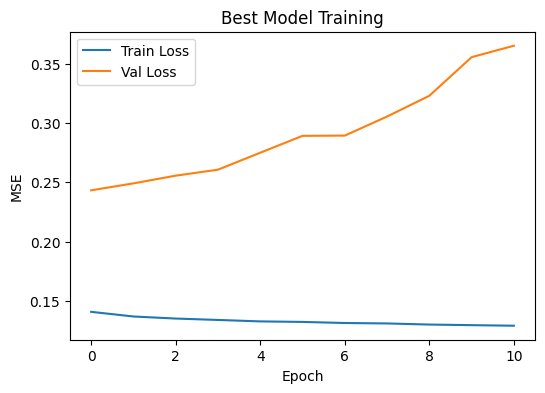

In [40]:
n_features = len(features)

def build_stacked_lstm(window_size, n_features, horizon,
                       units1, units2, dropout1, dropout2, lr):
    model = Sequential()
    # LSTM layer 1
    model.add(LSTM(units1,
                   return_sequences=True,
                   input_shape=(window_size, n_features)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout1))
    # LSTM layer 2
    model.add(LSTM(units2, return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(dropout2))
    # Dense output
    model.add(Dense(horizon, activation='linear'))
    # Compile
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse',
        metrics=['mae']
    )
    return model


def build_model_hp(hp):
    return build_stacked_lstm(
        window_size=window_size,
        n_features=n_features,
        horizon=horizon,
        units1=hp.Choice('units1', [64, 128, 256]),
        units2=hp.Choice('units2', [32, 64, 128]),
        dropout1=hp.Float('dropout1', 0.1, 0.5, step=0.1),
        dropout2=hp.Float('dropout2', 0.1, 0.5, step=0.1),
        lr=hp.Choice('lr', [1e-2, 1e-3, 1e-4])
    )


tuner = RandomSearch(
    build_model_hp,
    objective='val_loss',    
    max_trials=20,             
    executions_per_trial=1,
    directory='rs_lstm',
    project_name='lstm_rs'
)


tuner.search(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ],
    verbose=1
)

best_hp    = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

print("Best hyperparameters found:")
print(f"  units1   = {best_hp.get('units1')}")
print(f"  units2   = {best_hp.get('units2')}")
print(f"  dropout1 = {best_hp.get('dropout1'):.2f}")
print(f"  dropout2 = {best_hp.get('dropout2'):.2f}")
print(f"  lr       = {best_hp.get('lr')}")

history = best_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ],
    verbose=2
)

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],  label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Best Model Training')
plt.legend()
plt.show()


In [ ]:
X_test, y_test = make_sequences(dftest, features, target, window_size, horizon)
y_pred = best_model.predict(X_test)
model_eval(y_test, y_pred)

2314/2314 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
(74038, 1, 14) (74038, 6)
Mean Squared Error: 0.3602813176658303
Mean Absolute Error: 0.22521809061487577
R-squared: 0.19775535875952385
Pearson Correlation Coefficient: 0.5125675510297845


# Weather forcast result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

C:\Users\Dell\AppData\Local\Temp\ipykernel_2412\2953863488.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


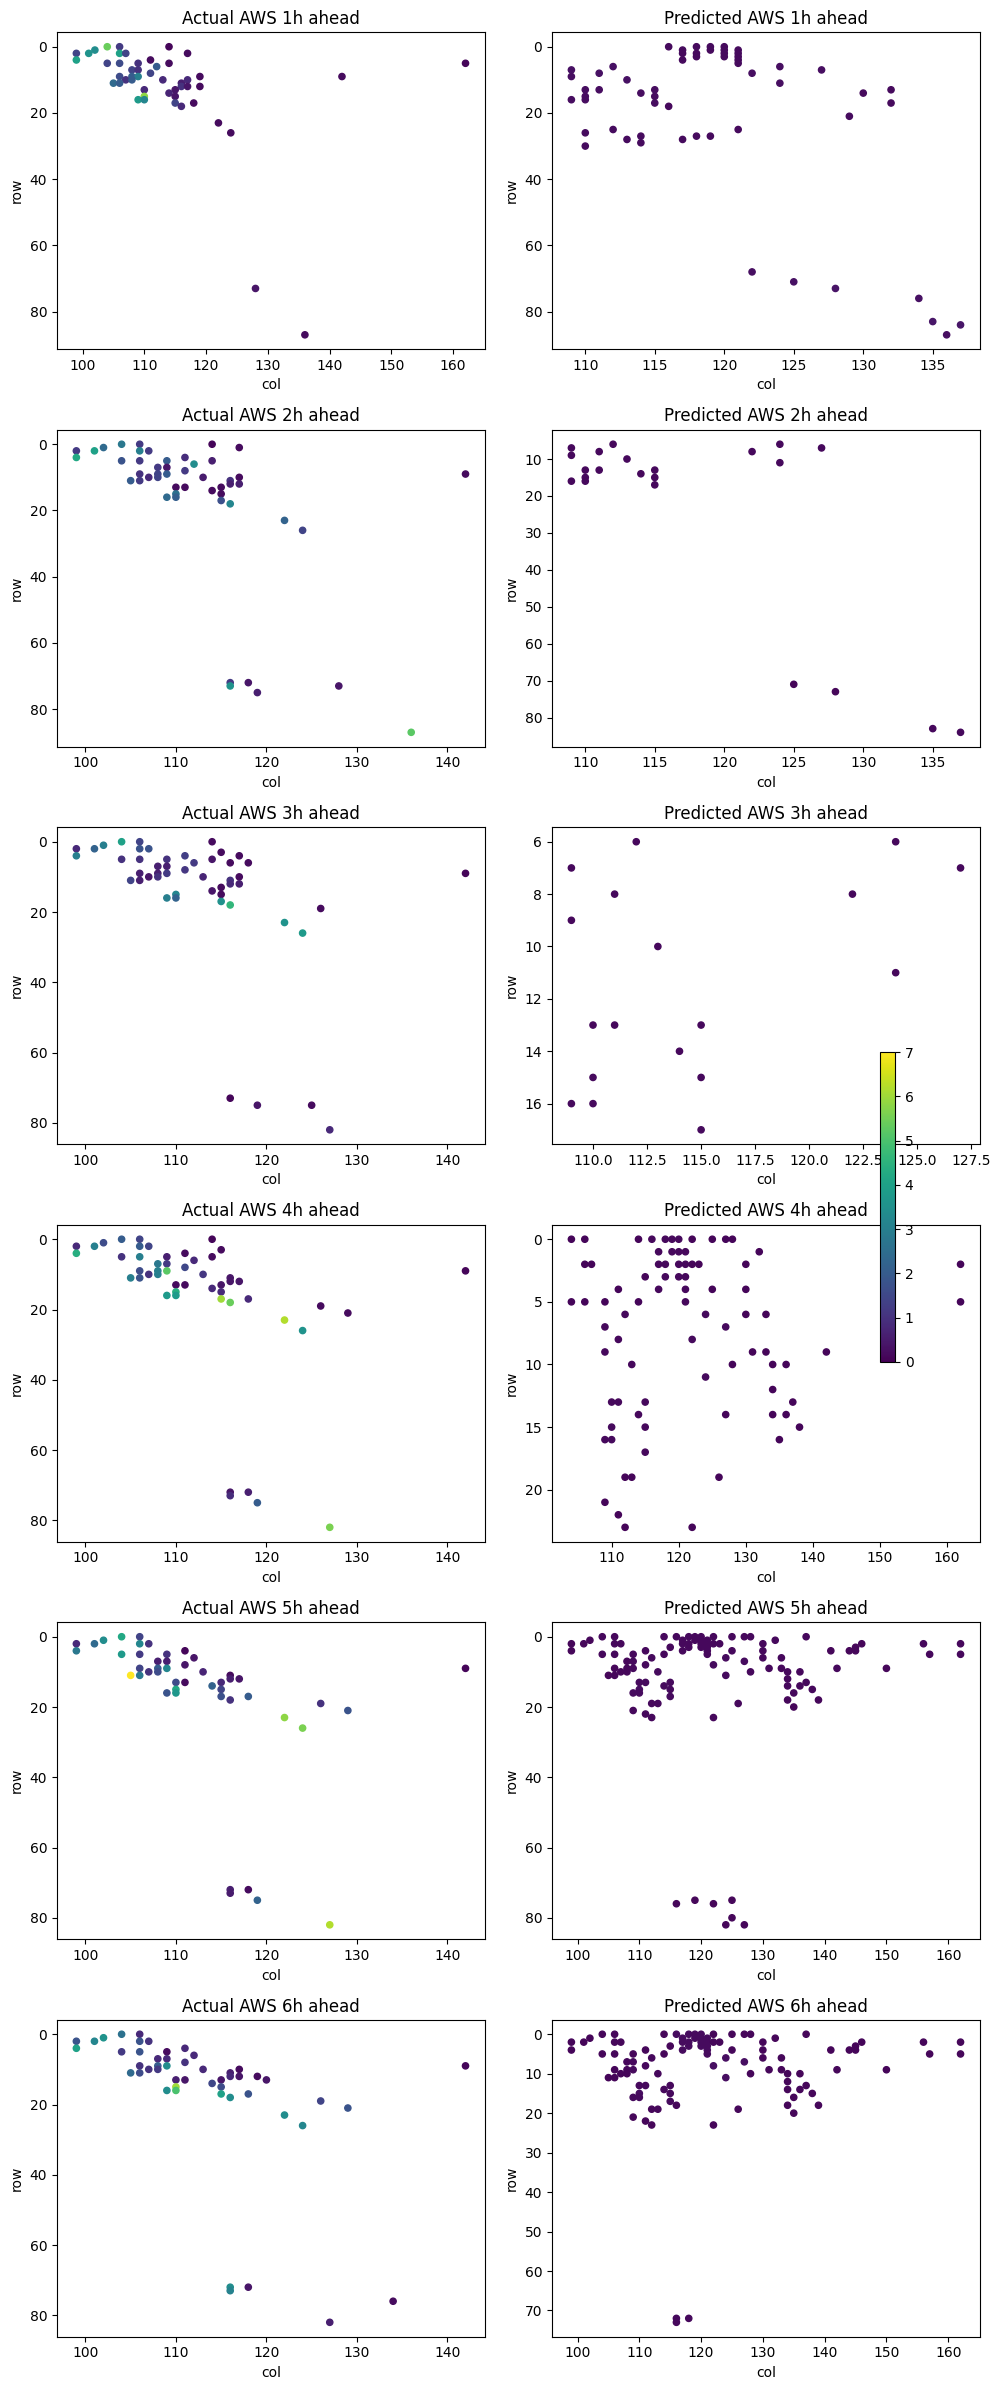

In [77]:
from datetime import timedelta


test_day   = pd.to_datetime('2020-10-29 9:00')
prev_times = [test_day - timedelta(hours=i) for i in range(window_size, 0, -1)]


coord_cols = ['row', 'col']
df2020     = df[df['datetime'].dt.year == 2020].copy()
grid       = df2020[coord_cols].drop_duplicates().reset_index(drop=True)
nP         = len(grid)
pred_map = np.full((horizon, nP), np.nan)
act_map  = np.full((horizon, nP), np.nan)

for idx, pt in grid.iterrows():
    cond   = (df2020['row']==pt['row']) & (df2020['col']==pt['col'])
    df_loc = df2020[cond].sort_values('datetime').reset_index(drop=True)
    df_win = df_loc[df_loc['datetime'].isin(prev_times)]
    if len(df_win) != window_size:
        continue
    
    Xd    = df_win[features].values.reshape(1, window_size, len(features))
    y_l   = best_model.predict(Xd).flatten()      
    pred_map[:, idx] = y_l
    
    df_act = df_loc[
        (df_loc['datetime'] >= test_day) &
        (df_loc['datetime'] <  test_day + timedelta(hours=horizon))
    ].sort_values('datetime')
    if len(df_act) != horizon:
        continue
    act_map[:, idx] = df_act[target].values

print(f"Built maps for {nP} points.")

vmin = np.nanmin(act_map)
vmax = np.nanmax(act_map)

pred_map[pred_map <= 0.1 ] = np.nan
act_map[act_map == 0 ] = np.nan

fig, axes = plt.subplots(nrows=horizon, ncols=2, figsize=(10, 4*horizon))
for h in range(horizon):
    ax1, ax2 = axes[h]
    sc1 = ax1.scatter(
        grid['col'], grid['row'], c=act_map[h],
        s=20, vmin=vmin, vmax=vmax
    )
    ax1.set_title(f'Actual AWS {h+1}h ahead')
    ax1.invert_yaxis()
    ax1.set_xlabel('col'); ax1.set_ylabel('row')

    sc2 = ax2.scatter(
        grid['col'], grid['row'], c=pred_map[h],
        s=20, vmin=vmin, vmax=vmax
    )
    ax2.set_title(f'Predicted AWS {h+1}h ahead')
    ax2.invert_yaxis()
    ax2.set_xlabel('col'); ax2.set_ylabel('row')

fig.colorbar(sc1, ax=axes, orientation='vertical', fraction=0.02)
plt.tight_layout()
plt.show()
